### https://www.kaggle.com/code/zubinrelia/car-insurance-claim-classifier

# 1. Import

In [1]:
import re
import shap
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

# 2. Preprocessing & Feature EDA

In [2]:
df = pd.read_csv("archive/train.csv")
# df.head()

In [3]:
df=df.drop('policy_id', axis=1)

In [4]:
df['torque'] = df['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
df['rpm'] = df['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

# Convert the columns to numeric data type
df['torque'] = pd.to_numeric(df['torque'])
df['rpm'] = pd.to_numeric(df['rpm'])

# Calculate torque to RPM ratio 
df['torque_rpm'] = df['torque'] / df['rpm']

In [5]:
# Deleting redundant columns from training set
df.drop('max_torque', axis=1,inplace=True)
df.drop('rpm',axis=1,inplace=True)
df.drop('torque',axis=1,inplace=True)

In [6]:
df['power'] = df['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])
df['rpm'] = df['max_power'].apply(lambda x: re.findall(r'\d+', x)[-1])

# Convert the columns to numeric data type
df['power'] = pd.to_numeric(df['power'])
df['rpm'] = pd.to_numeric(df['rpm'])

# Calculate power to RPM ratio
df['power_rpm'] = df['power'] / df['rpm']

In [7]:
df.drop('power', axis=1,inplace=True)
df.drop('rpm',axis=1,inplace=True)
df.drop('max_power',axis=1,inplace=True)

In [8]:
df = df.replace({ "No" : 0 , "Yes" : 1 })

In [9]:
is_cols=[col for col in df.columns if col.startswith("is") and col!="is_claim"]

In [10]:
dataset_num_col = df.select_dtypes(include=['int', 'float', 'bool']).columns

In [11]:
dataset_cat_cols = df.select_dtypes(include=['object']).columns

In [12]:
df= pd.get_dummies(df, columns=dataset_cat_cols,drop_first=True)

In [13]:
df_0 = df[df['is_claim'] == 0].sample(n=5000, random_state=21)
df_1 = df[df['is_claim'] == 1].sample(n=3000, random_state=21)

df = pd.concat([df_0, df_1], ignore_index=True)

In [14]:
df = df.sample(frac=1, random_state=42, ignore_index=True)

In [15]:
_df = df.copy()

In [16]:
def normalize(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return normalized_column

for column in dataset_num_col:
    df[column] = normalize(df[column])

In [17]:
# scale_dict = dict(enumerate(df.drop(columns = "is_claim").max() - df.drop(columns = "is_claim").min()))
# scale_list = list(sorted(scale_dict, key=scale_dict.get))
# print(scale_list)

In [18]:
# df.columns.get_indexer(dataset_num_col)

In [19]:
X = df.drop(columns = "is_claim")
y = df["is_claim"]

In [20]:
# from imblearn.combine import SMOTEENN 
# smt = SMOTEENN()
# X, y = smt.fit_resample(X, y)

In [21]:
# X_train = X.iloc[int(X.shape[0]*0.2):, :]
# X_val = X.iloc[:int(X.shape[0]*0.2), :]
# y_train = y[int(y.shape[0]*0.2):]
# y_val = y[:int(y.shape[0]*0.2)]

In [22]:
X_train = np.array(X.iloc[:int(X.shape[0]*0.8), :], dtype='float64')
X_val = np.array(X.iloc[int(X.shape[0]-X.shape[0]*0.2):int(X.shape[0]-X.shape[0]*0.1), :], dtype='float64')
X_test = np.array(X.iloc[-int(X.shape[0]*0.1):, :], dtype='float64')
y_train = np.array(y[:int(X.shape[0]*0.8)], dtype='float64')
y_val = np.array(y[int(X.shape[0]-X.shape[0]*0.2):int(X.shape[0]-X.shape[0]*0.1)], dtype='float64')
y_test = np.array(y[-int(X.shape[0]*0.1):], dtype='float64')

# 1 Classification Task:

In [23]:
acc_list = []
f1_list = []

## 1-1 Linear Classifier

In [24]:
class Perceptron:
    def __init__(self, lr=0.1, eps=100):
        self.lr = lr
        self.eps = eps
        self.w = None
        self.b = None
        self.Training = []
        self.Validation = []

    def fit(self, X_train, X_val, y_train, y_val):
        num_samples, num_features = X_train.shape
        self.w = np.zeros(num_features)
        self.b = 0

        for ep in tqdm(range(self.eps)):
            y_pred = self.predict(X_train)
            acc = self.accuracy(y_pred, y_train)
            loss = self.loss(y_pred, y_train)
            self.Training.append(loss)
            
            y_val_pred = self.predict(X_val)
            acc_val = self.accuracy(y_val_pred, y_val)
            loss_val = self.loss(y_val_pred, y_val)
            self.Validation.append(loss_val)
            
            dw = (1 / num_samples) * np.dot(X_train.T, (y_pred - y_train))
            db = (1 / num_samples) * np.sum(y_pred - y_train)

            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db
        print(f'Perceptron Accuracy: {acc}, Loss: {loss} ')

    def predict(self, x):
        lm = np.dot(x, self.w) + self.b
        y_pred = self.sigmoid(lm)
        return y_pred
    
    def accuracy(self, y_pred, y_true):
        return np.sum((y_pred > 0.5).astype(int) == y_true) / len(y_true)
    
    def precision(self, y_pred, y_true):
        true_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 1).astype(int))
        false_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 0).astype(int))
        return true_positives / (true_positives + false_positives)
    
    def recall(self, y_pred, y_true):
        true_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 1).astype(int))
        false_negatives = np.sum((y_pred <= 0.5).astype(int) & (y_true == 1).astype(int))
        return true_positives / (true_positives + false_negatives)
    
    def f1_score(self, y_pred, y_true):
        precision_value = self.precision(y_pred, y_true)
        recall_value = self.recall(y_pred, y_true)
        return 2 * (precision_value * recall_value) / (precision_value + recall_value)
    
    def loss(self, y_pred, y_true):
        return np.mean(- (y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15)))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def acc_loss_plot(self):
        plt.plot(self.Training, label='Training', marker='o')
        plt.plot(self.Validation, label='Validation', marker='x')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        
        plt.legend()
        plt.show()

In [25]:
perceptron = Perceptron()
perceptron.fit(X_train, X_val, y_train, y_val)
# Train
y_pred = perceptron.predict(X_train)
accuracy = perceptron.accuracy(y_pred, y_train)
# Val
y_pred = perceptron.predict(X_val)
accuracy = perceptron.accuracy(y_pred, y_val)
acc_list.append(accuracy)
f1_list.append(perceptron.f1_score(y_pred, y_val))

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2777.83it/s]

Perceptron Accuracy: 0.62640625, Loss: 0.6555005633977021 



invalid value encountered in scalar divide


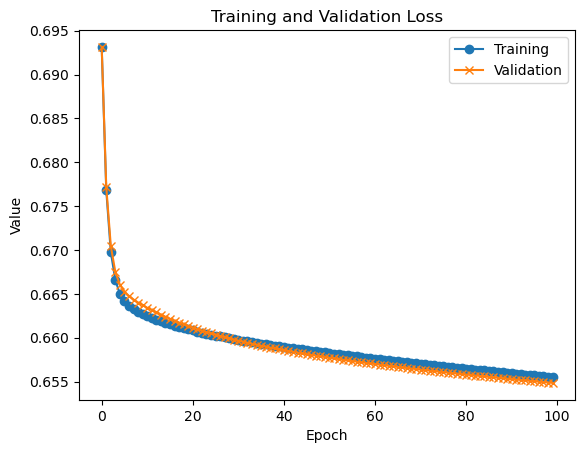

In [26]:
perceptron.acc_loss_plot()

## 1-2 K-NN Classifier

In [27]:
class KDNode:
    def __init__(self, col=None, data=None, left=None, right=None):
        self.col = col
        self.data = data
        self.left = left
        self.right = right

class KDTree:
    def __init__(self, k, data, labels, metric='Euclidean'):
        self.k = k
        self.cols = data.shape[1]
        self.metric = metric
        self.root = self.createNode(0, data, labels)

    def createNode(self, col, data, labels):
        if data.shape[0] == 0:
            return None
        
        data_sort = data[data[:, col].argsort()]
        data_left = data_sort[:data_sort.shape[0]//2]
        data_right = data_sort[data_sort.shape[0]//2:]
        
        if data.shape[0] <= 1:
            return KDNode(col=col, data=data_sort, left=None, right=None)
        
        col = (col+1) % self.cols
        left = self.createNode(col, data_left, labels)
        right = self.createNode(col, data_right, labels)
        
        return KDNode(col=col, data=data_sort, left=left, right=right)

    def distance(self, point1, point2):
        if self.metric == 'Euclidean':
            return np.sqrt(np.sum((point1 - point2) ** 2))
        elif self.metric == 'Manhattan':
            return np.sum(np.abs(point1 - point2))
        elif self.metric == 'Chebyshev':
            return np.abs(point1 - point2).max()
        else:
            raise ValueError("Error")

    def nearest(self, k=3, point=None):
        self.k = k
        self.ks = k*100
        self.dist = []
        self.near = []
        self.index = []
        self.k_nearest = []
        self.point = point

        def search(node):
            if node is None:
                return

            next_node = None
            if point[node.col] < node.data[:, node.col].mean():
                next_node = node.left
            else:
                next_node = node.right
            
            if next_node.data.shape[0] > self.ks:
                search(next_node)
            else:
                for i in node.data:
                    self.near.append(self.distance(self.point, i))
                self.index = np.argsort(self.near)
                self.dist = [self.near[i] for i in self.index[:self.k]]
                self.k_nearest = [node.data[i] for i in self.index[:self.k]]
                
        search(self.root)
        return self.index[:self.k]

class KNN:
    def __init__(self, k=3, metric='Euclidean'):
        self.k = k
        self.tree = None
        self.metric = metric

    def fit(self, X_train, X_val, y_train, y_val):
        if self.metric == 'Euclidean':
            self.tree = KDTree(self.k, X_train, y_train, metric='Euclidean')
        elif self.metric == 'Manhattan':
            self.tree = KDTree(self.k, X_train, y_train, metric='Manhattan')
        elif self.metric == 'Chebyshev':
            self.tree = KDTree(self.k, X_train, y_train, metric='Chebyshev')
        else:
            raise ValueError('Error')

    def predict(self, x):
        y_pred = []
        for i in tqdm(range(len(x))):
            NN = self.tree.nearest(self.k, x[i, :])
            labels = [y_train[i] for i in NN]
            majority = np.argmax(np.bincount(labels))
            y_pred.append(majority)
        y_pred = np.array(y_pred)
        acc = self.accuracy(y_pred, y_val)
        print(f'KNN Metric: {self.metric} Accuracy: {acc} ')
        return y_pred
    
    def accuracy(self, y_pred, y_true):
        return np.sum((y_pred > 0.5).astype(int) == y_true) / len(y_true)
    
    def precision(self, y_pred, y_true):
        true_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 1).astype(int))
        false_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 0).astype(int))
        return true_positives / (true_positives + false_positives)
    
    def recall(self, y_pred, y_true):
        true_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 1).astype(int))
        false_negatives = np.sum((y_pred <= 0.5).astype(int) & (y_true == 1).astype(int))
        return true_positives / (true_positives + false_negatives)
    
    def f1_score(self, y_pred, y_true):
        precision_value = self.precision(y_pred, y_true)
        recall_value = self.recall(y_pred, y_true)
        return 2 * (precision_value * recall_value) / (precision_value + recall_value)

In [28]:
knn = KNN(k=20, metric='Euclidean')
knn.fit(X_train, X_val, y_train, y_val)
# Train
y_pred = knn.predict(X_train)
accuracy1 = knn.accuracy(y_pred, y_train)
# Val
y_pred = knn.predict(X_val)
accuracy1 = knn.accuracy(y_pred, y_val)

knn = KNN(k=20, metric='Manhattan')
knn.fit(X_train, X_val, y_train, y_val)
# Train
y_pred = knn.predict(X_train)
accuracy2 = knn.accuracy(y_pred, y_train)
# Val
y_pred = knn.predict(X_val)
accuracy2 = knn.accuracy(y_pred, y_val)

knn = KNN(k=20, metric='Chebyshev')
knn.fit(X_train, X_val, y_train, y_val)
# Train
y_pred = knn.predict(X_train)
accuracy3 = knn.accuracy(y_pred, y_train)
# Val
y_pred = knn.predict(X_val)
accuracy3 = knn.accuracy(y_pred, y_val)

acc_list.append(accuracy1)

f1_list.append(perceptron.f1_score(y_pred, y_val))

100%|████████████████████████████████████████████████████████████| 6400/6400 [03:57<00:00, 27.00it/s]
elementwise comparison failed; this will raise an error in the future.


KNN Metric: Euclidean Accuracy: 0.0 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:37<00:00, 21.57it/s]


KNN Metric: Euclidean Accuracy: 0.60125 


100%|████████████████████████████████████████████████████████████| 6400/6400 [03:29<00:00, 30.58it/s]


KNN Metric: Manhattan Accuracy: 0.0 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:28<00:00, 28.37it/s]


KNN Metric: Manhattan Accuracy: 0.60625 


100%|████████████████████████████████████████████████████████████| 6400/6400 [02:16<00:00, 46.76it/s]


KNN Metric: Chebyshev Accuracy: 0.0 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 57.27it/s]

KNN Metric: Chebyshev Accuracy: 0.60375 


## 1-3 Naïve Decision Tree Classifier

In [29]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.num_classes = len(set(y))
        self.num_features = X.shape[1]
        self.tree = self._build_tree(X, y)

    def _calculate_gini(self, y):
        m = len(y)
        if m == 0:
            return 0

        gini = 1.0
        for c in range(self.num_classes):
            p = np.sum(y == c) / m
            gini -= p**2

        return gini

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.num_classes)]
        best_gini = 1.0 - sum((n / m) * (num / m)**2 for num in num_parent)
        best_idx, best_thr = None, None

        for idx in range(self.num_features):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.num_classes
            num_right = num_parent.copy()

            for i in range(1, m):
                c = int(classes[i - 1])
                num_left[c] += 1.0
                num_right[c] -= 1.0
                gini_left = 1.0 - sum((num_left[x] / i)**2 for x in range(self.num_classes))
                gini_right = 1.0 - sum((num_right[x] / (m - i))**2 for x in range(self.num_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._build_tree(X_left, y_left, depth + 1)
                node.right = self._build_tree(X_right, y_right, depth + 1)

        return node

    def predict(self, X):
        y_pred = np.array([self._predict(inputs) for inputs in X])
        return y_pred

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
    def accuracy(self, y_pred, y_true):
        return np.sum((y_pred > 0.5).astype(int) == y_true) / len(y_true)
    
    def precision(self, y_pred, y_true):
        true_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 1).astype(int))
        false_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 0).astype(int))
        return true_positives / (true_positives + false_positives)
    
    def recall(self, y_pred, y_true):
        true_positives = np.sum((y_pred > 0.5).astype(int) & (y_true == 1).astype(int))
        false_negatives = np.sum((y_pred <= 0.5).astype(int) & (y_true == 1).astype(int))
        return true_positives / (true_positives + false_negatives)
    
    def f1_score(self, y_pred, y_true):
        precision_value = self.precision(y_pred, y_true)
        recall_value = self.recall(y_pred, y_true)
        return 2 * (precision_value * recall_value) / (precision_value + recall_value)

In [30]:
DT = DecisionTreeClassifier(max_depth=20)
DT.fit(X_train, y_train)
# Train
y_pred = DT.predict(X_train)
accuracy = DT.accuracy(y_pred, y_train)
# Val
y_pred = DT.predict(X_val)
accuracy = DT.accuracy(y_pred, y_val)

acc_list.append(accuracy)
f1_list.append(perceptron.f1_score(y_pred, y_val))

## 1-4 Decision Tree with Pruning

In [31]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class PruningDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        super().__init__(max_depth=max_depth)
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
    def pruning_fit(self, X, y):
        self.fit(X, y)
        self._prune(self.tree, X, y)
    
    def _prune(self, node, X, y):
        if node.left is not None or node.right is not None:
            if node.left is not None:
                self._prune(node.left, X, y)
            if node.right is not None:
                self._prune(node.right, X, y)

            if node.left is not None and node.right is not None:
                indices_left = X[:, node.feature_index] < node.threshold
                left_X = list(X[indices_left])
                right_y = list(X[~indices_left])
                left_pred = self.predict(left_X)
                right_pred = self.predict(right_y)
                merged_gini = (
                    len(left_X) * self._calculate_gini(left_pred) +
                    len(right_y) * self._calculate_gini(right_pred)
                ) / (len(left_X) + len(right_y))
                no_prune_gini = self._calculate_gini(self.predict(X))

                if merged_gini < no_prune_gini:
                    node.left = None
                    node.right = None

In [32]:
PDT = PruningDecisionTreeClassifier(max_depth=20)
PDT.pruning_fit(X_train, y_train)
y_pred = PDT.predict(X_val)
accuracy = PDT.accuracy(y_pred, y_val)
acc_list.append(accuracy)
f1_list.append(perceptron.f1_score(y_pred, y_val))

invalid value encountered in scalar divide


In [33]:
acc_list

[0.6275, 0.60125, 0.59625, 0.6275]

In [34]:
f1_list

[nan, 0.05934718100890207, 0.3800383877159309, nan]

# 2 Feature engineering:

## 2-1 Feature Importance - Perceptron

In [35]:
weights = perceptron.w
top = 5
importancy = (abs(weights).argsort())[-top:][::-1]
print(f"TOP {top} important features:")
for i in importancy:
    print(f"{X.columns[i]}: {weights[i]}")

important_X_train = np.array([X_train[:, i] for i in importancy]).T
important_X_val = np.array([X_val[:, i] for i in importancy]).T

perceptron.fit(important_X_train, important_X_val, y_train, y_val)
y_pred = perceptron.predict(important_X_val)

TOP 5 important features:
policy_tenure: 0.17944294959580157
is_speed_alert: -0.0776827605725189
is_power_steering: -0.07592879139019616
steering_type_Power: -0.07420995317686337
rear_brakes_type_Drum: -0.07413551962530754


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1960.81it/s]

Perceptron Accuracy: 0.62640625, Loss: 0.6580857729096711 


## 2-1 Feature Importance - Decision Tree

In [36]:
importancy = np.zeros(X_train.shape[1])

def dfs(node, depth=0):
    if node is None:
        return
    importancy[node.feature_index] += depth
    dfs(node.left, depth + 1)
    dfs(node.right, depth + 1)
dfs(DT.tree)
importancy = (importancy.argsort())[-top:][::-1]

print(f"TOP {top} important features:")
for i in importancy:
    print(f"{X.columns[i]}")
    
important_X_train = np.array([X_train[:, i] for i in importancy]).T
important_X_val = np.array([X_val[:, i] for i in importancy]).T

DT.fit(important_X_train, y_train)
y_pred = perceptron.predict(important_X_val)
accuracy = DT.accuracy(y_pred, y_val)

TOP 5 important features:
policy_tenure
age_of_policyholder
population_density
age_of_car
area_cluster_C19


In [37]:
accuracy

0.6275

## 2-2 SHAP

In [61]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train, y_train)

class SHAPWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, x):
        return self.model.predict(x)


shap_model = SHAPWrapper(DT)
explainer = shap.Explainer(shap_model, X_train)
explainer.feature_names = X.columns
shap_values = explainer(X_train)

PermutationExplainer explainer: 7201it [02:20, 47.60it/s]                                            


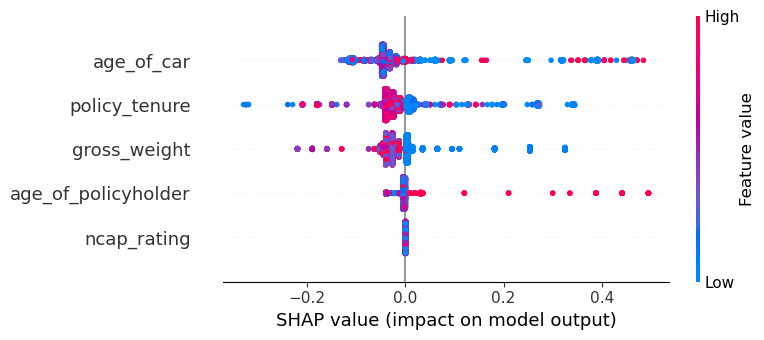

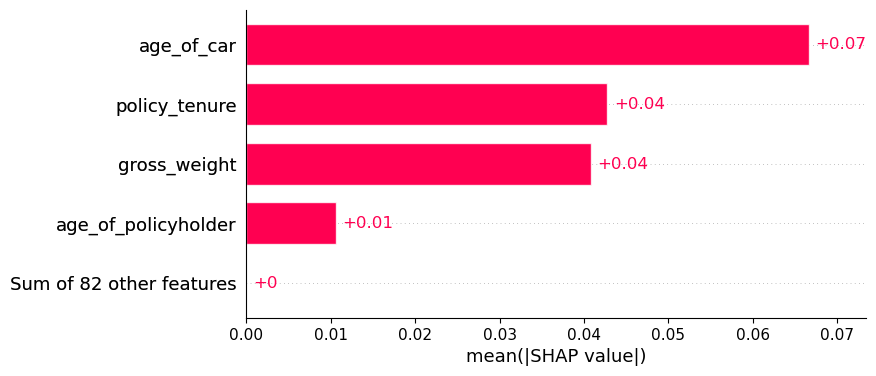

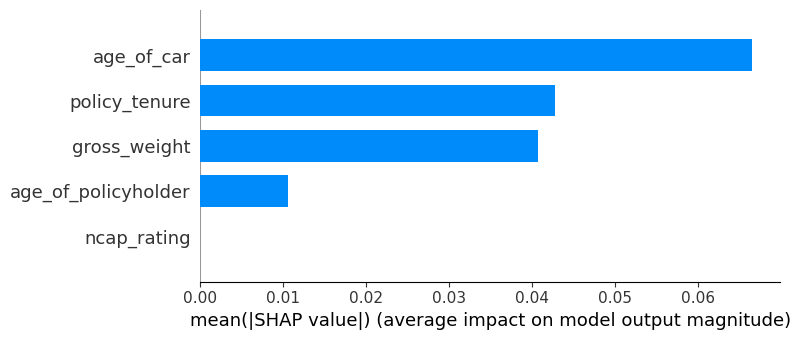

In [63]:
shap.summary_plot(shap_values, X_train, max_display=5, feature_names=X.columns)
shap.plots.bar(shap_values, max_display=5)
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar",show=False, max_display=5)

## 2-3 New Feature

In [40]:
_df.insert(0, 'age_of_car_policyholder', df['age_of_car'] * df['age_of_policyholder'])
_df.insert(0, 'displacement_policy_tenure', df['displacement'] * df['policy_tenure'])

In [41]:
def normalize(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return normalized_column

for column in dataset_num_col:
    _df[column] = normalize(_df[column])

In [42]:
_X = _df.drop(columns = "is_claim")
_y = _df["is_claim"]

In [43]:
_X_train = np.array(_X.iloc[:int(_X.shape[0]*0.8), :], dtype='float64')
_X_val = np.array(_X.iloc[int(X.shape[0]-_X.shape[0]*0.2):int(_X.shape[0]-_X.shape[0]*0.1), :], dtype='float64')
_X_test = np.array(_X.iloc[-int(_X.shape[0]*0.1):, :], dtype='float64')
_y_train = np.array(_y[:int(_X.shape[0]*0.8)], dtype='float64')
_y_val = np.array(_y[int(_X.shape[0]-_X.shape[0]*0.2):int(_X.shape[0]-_X.shape[0]*0.1)], dtype='float64')
_y_test = np.array(_y[-int(_X.shape[0]*0.1):], dtype='float64')

In [44]:
DT = DecisionTreeClassifier(max_depth=20)
DT.fit(_X_train, _y_train)
_y_pred = DT.predict(_X_val)
accuracy = DT.accuracy(_y_pred, _y_val)

In [45]:
print('New Feature Accuracy : Before:', acc_list[2], 'After:', accuracy)

New Feature Accuracy : Before: 0.59625 After: 0.61875


# 3 Cross-Validation

## 3-1 k-fold(k=3, 5, 10)

In [46]:
from sklearn.model_selection import KFold

In [47]:
fold_record = []
fold_model_record = []
k_values = [3, 5, 10]

for k in k_values:
    print(f"\nPerforming {k}-fold Cross-Validation:")

    kf = KFold(n_splits=k, shuffle=True, random_state=21)
    acc_record = [[], [], [], []]
    model_record = [[], [], [], []]
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = np.array(X.iloc[train_index, :]), np.array(X.iloc[val_index, :])
        y_train, y_val = np.array(y.iloc[train_index]), np.array(y.iloc[val_index])
        print(f"K: {k} Fold: {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
        
        perceptron = Perceptron()
        perceptron.fit(X_train, X_val, y_train, y_val)
        y_pred = perceptron.predict(X_val)
        accuracy0 = perceptron.accuracy(y_pred, y_val)
        acc_record[0].append(accuracy0)
        model_record[0].append(perceptron)
        
        knn = KNN(k=20, metric='Euclidean')
        knn.fit(X_train, X_val, y_train, y_val)
        y_pred = knn.predict(X_val)
        accuracy1 = knn.accuracy(y_pred, y_val)
        acc_record[1].append(accuracy1)
        model_record[1].append(knn)
        
        DT = DecisionTreeClassifier(max_depth=20)
        DT.fit(X_train, y_train)
        y_pred = DT.predict(X_val)
        accuracy2 = DT.accuracy(y_pred, y_val)
        print('DecisionTree acc = ', accuracy)
        acc_record[2].append(accuracy2)
        model_record[2].append(DT)
        
        PDT = PruningDecisionTreeClassifier(max_depth=20)
        PDT.pruning_fit(X_train, y_train)
        y_pred = PDT.predict(X_val)
        accuracy3 = PDT.accuracy(y_pred, y_val)
        acc_record[3].append(accuracy3)
        model_record[3].append(PDT)
        print('PruningDecisionTree acc = ', accuracy)
        print('= ' * 30)
        
    fold_record.append(acc_record)
    fold_model_record.append(model_record)


Performing 3-fold Cross-Validation:
K: 3 Fold: 1: Train 5333 samples, Validation 2667 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1612.95it/s]


Perceptron Accuracy: 0.6294768423026439, Loss: 0.6532279971694603 


100%|████████████████████████████████████████████████████████████| 2667/2667 [01:24<00:00, 31.55it/s]


KNN Metric: Euclidean Accuracy: 0.5999250093738283 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 3 Fold: 2: Train 5333 samples, Validation 2667 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1612.87it/s]


Perceptron Accuracy: 0.6217888618038627, Loss: 0.6577071609540425 


100%|████████████████████████████████████████████████████████████| 2667/2667 [01:19<00:00, 33.73it/s]


KNN Metric: Euclidean Accuracy: 0.6089238845144357 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 3 Fold: 3: Train 5334 samples, Validation 2666 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1243.87it/s]


Perceptron Accuracy: 0.623734533183352, Loss: 0.6573162956082879 


100%|████████████████████████████████████████████████████████████| 2666/2666 [01:18<00:00, 33.94it/s]


KNN Metric: Euclidean Accuracy: 0.6117779444861215 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Performing 5-fold Cross-Validation:
K: 5 Fold: 1: Train 6400 samples, Validation 1600 samples


100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 958.30it/s]


Perceptron Accuracy: 0.62609375, Loss: 0.6557608262013221 


100%|████████████████████████████████████████████████████████████| 1600/1600 [01:01<00:00, 26.21it/s]


KNN Metric: Euclidean Accuracy: 0.6 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 5 Fold: 2: Train 6400 samples, Validation 1600 samples


100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 709.40it/s]

Perceptron Accuracy: 0.6271875, Loss: 0.6546470393262201 



100%|████████████████████████████████████████████████████████████| 1600/1600 [00:56<00:00, 28.16it/s]


KNN Metric: Euclidean Accuracy: 0.6 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 5 Fold: 3: Train 6400 samples, Validation 1600 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1033.35it/s]

Perceptron Accuracy: 0.6225, Loss: 0.6571707183451031 



100%|████████████████████████████████████████████████████████████| 1600/1600 [01:02<00:00, 25.48it/s]


KNN Metric: Euclidean Accuracy: 0.611875 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 5 Fold: 4: Train 6400 samples, Validation 1600 samples


100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 769.00it/s]

Perceptron Accuracy: 0.62515625, Loss: 0.6561888404901762 



100%|████████████████████████████████████████████████████████████| 1600/1600 [00:58<00:00, 27.21it/s]


KNN Metric: Euclidean Accuracy: 0.60375 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 5 Fold: 5: Train 6400 samples, Validation 1600 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1449.08it/s]


Perceptron Accuracy: 0.6240625, Loss: 0.6570180070078977 


100%|████████████████████████████████████████████████████████████| 1600/1600 [00:59<00:00, 26.99it/s]


KNN Metric: Euclidean Accuracy: 0.611875 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Performing 10-fold Cross-Validation:
K: 10 Fold: 1: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1017.67it/s]


Perceptron Accuracy: 0.6248611111111111, Loss: 0.6566763675505616 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:32<00:00, 24.74it/s]


KNN Metric: Euclidean Accuracy: 0.59625 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 2: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1459.52it/s]


Perceptron Accuracy: 0.6261111111111111, Loss: 0.6554138553565892 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:34<00:00, 22.88it/s]


KNN Metric: Euclidean Accuracy: 0.60125 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 3: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1551.29it/s]


Perceptron Accuracy: 0.6254166666666666, Loss: 0.6556276221945574 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:32<00:00, 24.95it/s]


KNN Metric: Euclidean Accuracy: 0.605 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 4: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1228.19it/s]

Perceptron Accuracy: 0.6265277777777778, Loss: 0.6554970268059171 



100%|██████████████████████████████████████████████████████████████| 800/800 [00:29<00:00, 26.91it/s]


KNN Metric: Euclidean Accuracy: 0.59 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 5: Train 7200 samples, Validation 800 samples


100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 731.24it/s]

Perceptron Accuracy: 0.6248611111111111, Loss: 0.6564031028501675 



100%|██████████████████████████████████████████████████████████████| 800/800 [00:30<00:00, 26.17it/s]


KNN Metric: Euclidean Accuracy: 0.6125 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 6: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1575.04it/s]


Perceptron Accuracy: 0.6229166666666667, Loss: 0.6570230639691612 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:34<00:00, 23.33it/s]


KNN Metric: Euclidean Accuracy: 0.61625 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 7: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1441.22it/s]


Perceptron Accuracy: 0.6231944444444445, Loss: 0.6572915738071795 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:33<00:00, 23.76it/s]


KNN Metric: Euclidean Accuracy: 0.6125 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 8: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1515.12it/s]


Perceptron Accuracy: 0.6269444444444444, Loss: 0.6552770156576533 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:31<00:00, 25.39it/s]


KNN Metric: Euclidean Accuracy: 0.585 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 9: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2893.86it/s]


Perceptron Accuracy: 0.6241666666666666, Loss: 0.6568594143751276 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 87.38it/s]


KNN Metric: Euclidean Accuracy: 0.61125 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
K: 10 Fold: 10: Train 7200 samples, Validation 800 samples


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2889.10it/s]


Perceptron Accuracy: 0.625, Loss: 0.6563973047414472 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 84.53it/s]


KNN Metric: Euclidean Accuracy: 0.60375 
DecisionTree acc =  0.61875
PruningDecisionTree acc =  0.61875
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [48]:
# fold_record

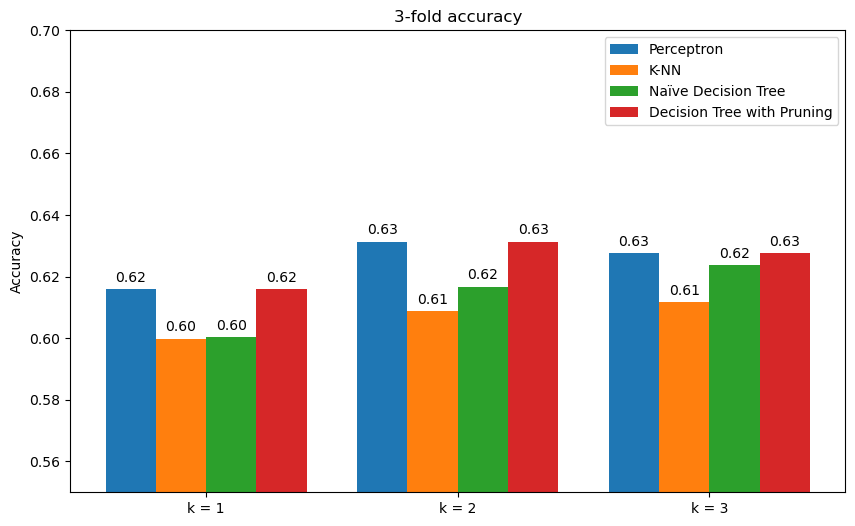

In [49]:
k = [f'k = {i+1}' for i in range(len(fold_record[0][0]))]
acc = {
    'Perceptron': fold_record[0][0],
    'K-NN': fold_record[0][1],
    'Naïve Decision Tree': fold_record[0][2],
    'Decision Tree with Pruning': fold_record[0][3]
}

x = np.arange(len(k))
width = 0.2
multiplier = 0

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for attribute, measurement in acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

ax.set_ylim(0.55, 0.7)
ax.set_ylabel('Accuracy')
ax.set_title('3-fold accuracy')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(k)
ax.legend(loc='upper right')

plt.show()


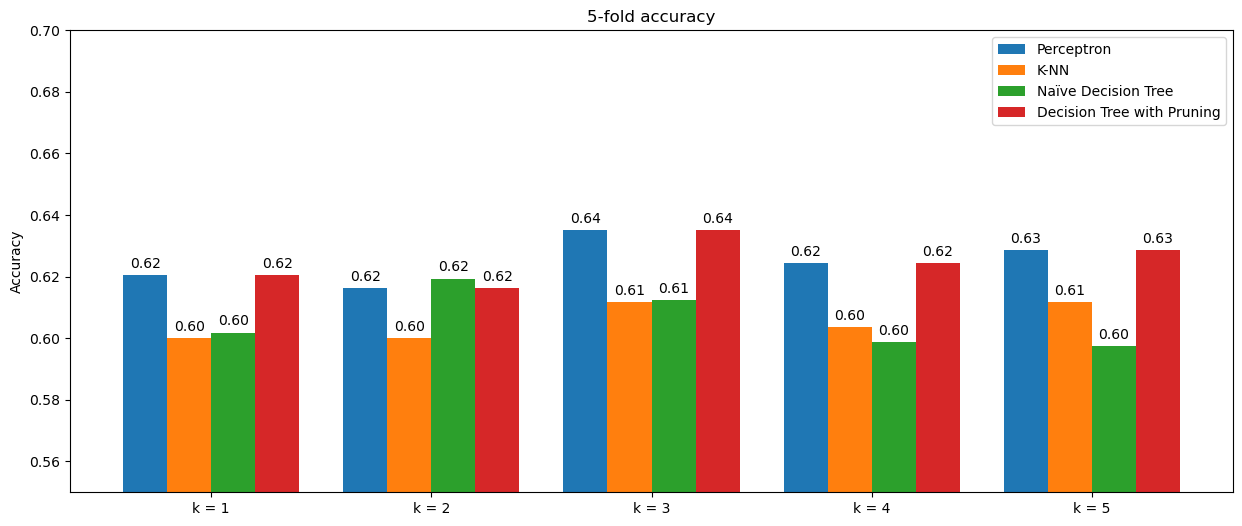

In [50]:
k = [f'k = {i+1}' for i in range(len(fold_record[1][0]))]
acc = {
    'Perceptron': fold_record[1][0],
    'K-NN': fold_record[1][1],
    'Naïve Decision Tree': fold_record[1][2],
    'Decision Tree with Pruning': fold_record[1][3]
}

x = np.arange(len(k))
width = 0.2
multiplier = 0

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
for attribute, measurement in acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

ax.set_ylim(0.55, 0.7)
ax.set_ylabel('Accuracy')
ax.set_title('5-fold accuracy')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(k)
ax.legend(loc='upper right')

plt.show()


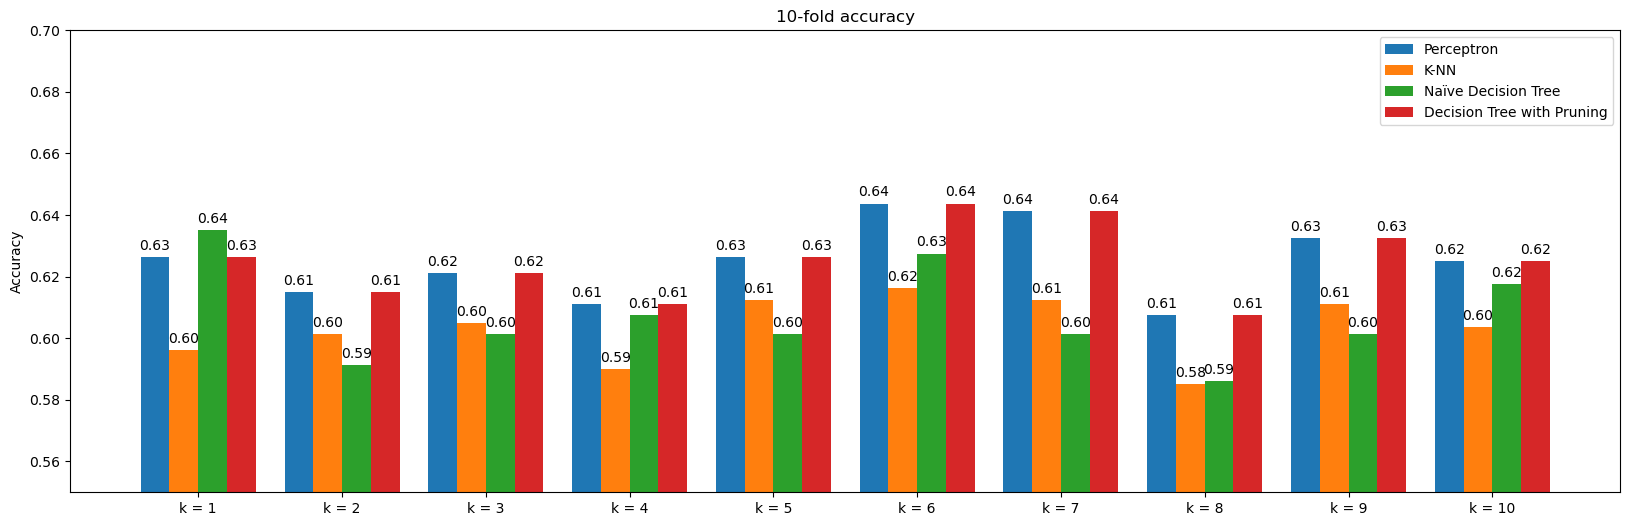

In [51]:
k = [f'k = {i+1}' for i in range(len(fold_record[2][0]))]
acc = {
    'Perceptron': fold_record[2][0],
    'K-NN': fold_record[2][1],
    'Naïve Decision Tree': fold_record[2][2],
    'Decision Tree with Pruning': fold_record[2][3]
}

x = np.arange(len(k))
width = 0.2
multiplier = 0

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
for attribute, measurement in acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

ax.set_ylim(0.55, 0.7)
ax.set_ylabel('Accuracy')
ax.set_title('10-fold accuracy')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(k)
ax.legend(loc='upper right')

plt.show()


## 3-2 Predict test 

In [52]:
fold_model_record[0][0][0].predict(X_test)
k_fold = []
for k in fold_model_record:
    classifier_acc_mean = []
    for classifier in k:
        arr = [c.predict(X_test) for c in classifier]
        mean_preds = np.mean(arr, axis=0)
        mean_acc = classifier[0].accuracy(mean_preds, y_test)
        classifier_acc_mean.append(mean_acc)
    k_fold.append(classifier_acc_mean)
    print('= '*30)

100%|█████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 119.52it/s]


KNN Metric: Euclidean Accuracy: 0.61375 


100%|█████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 119.94it/s]


KNN Metric: Euclidean Accuracy: 0.5825 


100%|█████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 116.71it/s]


KNN Metric: Euclidean Accuracy: 0.62375 
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 97.81it/s]


KNN Metric: Euclidean Accuracy: 0.59375 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 98.16it/s]


KNN Metric: Euclidean Accuracy: 0.60875 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 97.65it/s]


KNN Metric: Euclidean Accuracy: 0.59375 


100%|█████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.56it/s]


KNN Metric: Euclidean Accuracy: 0.615 


100%|█████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 102.93it/s]


KNN Metric: Euclidean Accuracy: 0.61 
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 90.76it/s]


KNN Metric: Euclidean Accuracy: 0.6225 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 91.23it/s]


KNN Metric: Euclidean Accuracy: 0.60375 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 86.94it/s]


KNN Metric: Euclidean Accuracy: 0.595 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 85.69it/s]


KNN Metric: Euclidean Accuracy: 0.58375 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 87.65it/s]


KNN Metric: Euclidean Accuracy: 0.58875 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 90.23it/s]


KNN Metric: Euclidean Accuracy: 0.6025 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 92.03it/s]


KNN Metric: Euclidean Accuracy: 0.63 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 91.53it/s]


KNN Metric: Euclidean Accuracy: 0.6175 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 88.16it/s]


KNN Metric: Euclidean Accuracy: 0.6125 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 86.00it/s]

KNN Metric: Euclidean Accuracy: 0.615 
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [53]:
k_fold.insert(0, acc_list)

In [54]:
k_fold = np.array(k_fold).T

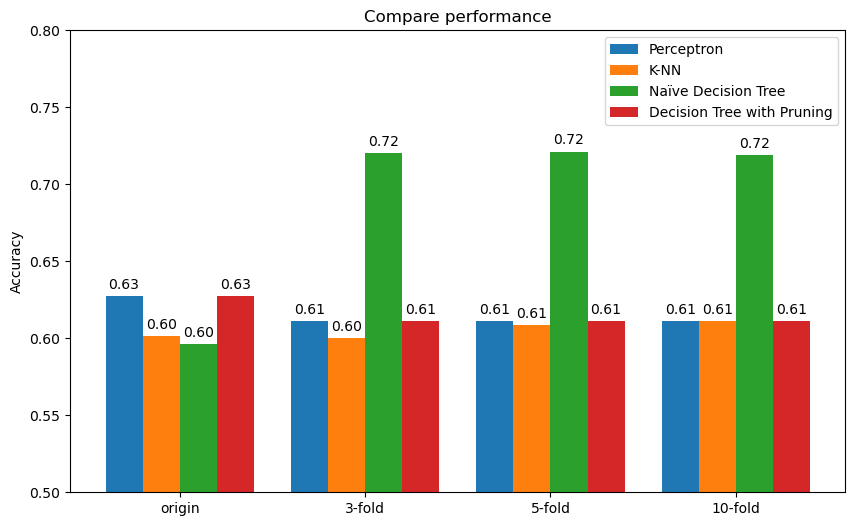

In [55]:
k = ['origin', '3-fold', '5-fold', '10-fold']
classifiers = ['Perceptron', 'K-NN', 'Naïve Decision Tree', 'Decision Tree with Pruning']

acc = {classifier: k_fold[idx] for idx, classifier in enumerate(classifiers)}

x = np.arange(len(k))
width = 0.2
multiplier = 0

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for attribute, measurement in acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

ax.set_ylim(0.5, 0.8)
ax.set_ylabel('Accuracy')
ax.set_title('Compare performance')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(k)
ax.legend(loc='upper right')

plt.show()


## 3-3 Show better

In [56]:
classifier_f1_mean = []
for models in fold_model_record[1]:
    arr = [model.predict(X_test) for model in models]
    mean_preds = np.mean(arr, axis=0)
    mean_acc = models[0].f1_score(mean_preds, y_test)
    classifier_f1_mean.append(mean_acc)

invalid value encountered in scalar divide
100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 99.92it/s]


KNN Metric: Euclidean Accuracy: 0.59375 


100%|█████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.24it/s]


KNN Metric: Euclidean Accuracy: 0.60875 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 98.47it/s]


KNN Metric: Euclidean Accuracy: 0.59375 


100%|██████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 98.13it/s]


KNN Metric: Euclidean Accuracy: 0.615 


100%|█████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 101.27it/s]
invalid value encountered in scalar divide
invalid value encountered in scalar divide


KNN Metric: Euclidean Accuracy: 0.61 


In [57]:
print('F1_score : Before:', acc_list[2], 'After:', accuracy)

F1_score : Before: 0.59625 After: 0.61875
